In [64]:
import cv2
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cv2.__version__

'4.1.2'

In [305]:
#read images from the video
img_og=cv2.imread("Football_img.PNG",)
height, width, channels = img_og.shape
img=img_og.copy()

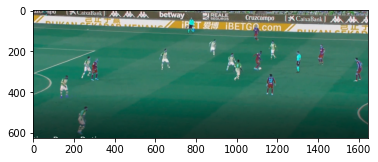

In [174]:
plt.imshow(img)


In [ ]:
img.shape

(626, 1646, 3)

In [ ]:
plt.imshow(img)

In [306]:
# Load Yolo
net = cv2.dnn.readNet( "yolov3.cfg","yolov3.weights")



#list of class names (we are only interested in 'persons')
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [ ]:
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

# Image Section

In [307]:
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), True, crop=False)

net.setInput(blob)
outs = net.forward(output_layers) #the actual forward pass through the YoLo network

In [308]:
def extract_boxes(outs): #outs is image passed through network
  # Showing informations on the screen
  class_ids = []
  confidence=0.4
  confidences = []
  boxes = []
  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence_instance = scores[class_id]
          if confidence_instance > confidence:
              # Computing values to draw bounding box
              center_x = int(detection[0] * width)
              center_y = int(detection[1] * height)
              w = int(detection[2] * width)
              h = int(detection[3] * height)

              # Coordinates for our rectangle
              x = int(center_x - w / 2)
              y = int(center_y - h / 2)

              boxes.append([x, y, w, h])
              confidences.append(float(confidence_instance))
              class_ids.append(class_id)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.35)
  return boxes,indexes,confidences,class_ids

In [309]:
def count_colored_pixels(image):
  return image.any(axis=-1).sum()

def team_detection(image):
  boundaries=[
              ([0,150,200],[50,255,255]), #yellow 
  ([15,15,100], [90,90,255]), #red
  ([50,10,10],[255,60,60]), #blue
  ([160,160,160],[255,255,255]) #white

  ]
  i=0
  for (lower,upper) in boundaries:

    lower=np.array(lower,dtype="uint8")
    upper=np.array(upper,dtype="uint8")



    mask=cv2.inRange(image,lower,upper)
    out=cv2.bitwise_and(image,image,mask=mask)
    total_pixels= count_colored_pixels(image)
    color_pixels=count_colored_pixels(out)
    color_total_ratio=color_pixels/total_pixels
    #print(color_total_ratio)
    if color_total_ratio>0.02 and i==0:
      return 'Ref'
    if color_total_ratio>0.02 and i==1:
      return 'Barca'
    elif color_total_ratio>0.01 and i==2:
      return 'Barca'
    elif color_total_ratio>0.04 and i==3:
      return 'Betis'

    i+=1
  return 'Nope'

In [312]:
%%time
boxes,indexes,confidence,class_ids=extract_boxes(outs)
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]

        if label=='person':
            """roi = img[y:y+h,x:x+w] #region of interest
            roi=cv2.resize(roi, (96,96))
            ym=model.predict(np.reshape(roi,(1,96,96,3)))
            ym=argmax(ym)
            """

            cropped_img=img[y:y+h,x:x+w]
            team=team_detection(cropped_img)
            if team=='Barca':
              color= np.array([255,0,0],dtype=np.float)
            elif team=='Barca':
              color= np.array([255,0,0],dtype=np.float)  
            elif team=='Betis':
              color= np.array([0,0,255],dtype=np.float)  
            elif team=='None':
              color = np.array([255,255,255],dtype=np.float)
            elif team=='Ref':
              color = np.array([0,255,255],dtype=np.float)
            """print(team)
            print(color)
            print(i)
            """
            
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, team, (x-2, y-2), font, 0.8, color, 2, cv2.LINE_AA)
            
            
            

CPU times: user 64.8 ms, sys: 0 ns, total: 64.8 ms
Wall time: 64.9 ms


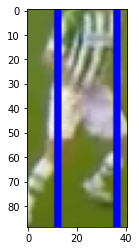

In [296]:
x,y,w,h=boxes[16
              
              ]
cropped_img=img[y:y+h,x:x+w]
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

In [213]:
cropped_img[40,20,:
            ]

array([145, 164, 178], dtype=uint8)

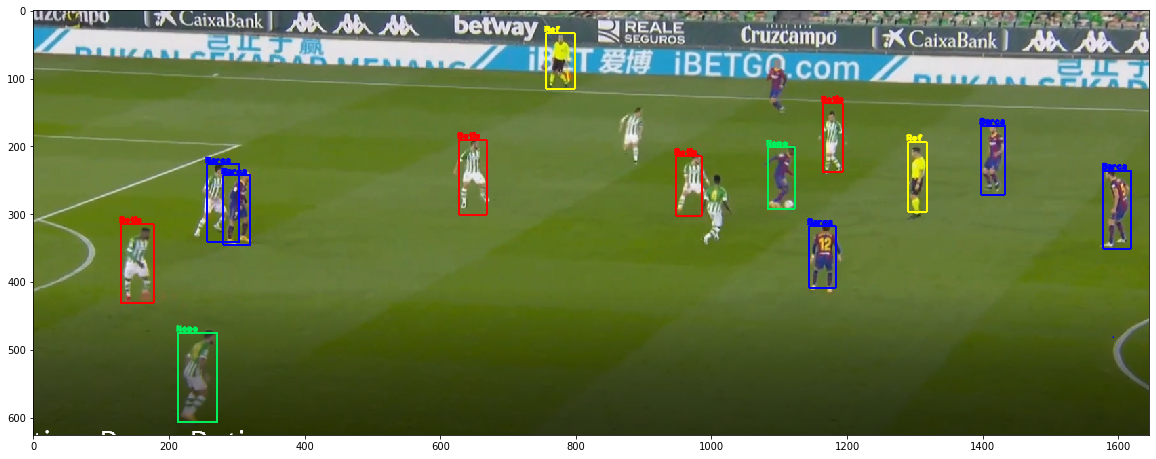

In [311]:
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),interpolation='nearest') 

# Video section

In [17]:

filename='BarBet.mp4'
cap=cv2.VideoCapture(filename)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
res=(int(width), int(height))
out = cv2.VideoWriter('/content/soccer_out.mp4',cv2.VideoWriter_fourcc(*'mp4v'),20,res  )
j=0


while True:
  try:
    hasFrame,frame=cap.read()
  except cv2.error:
    continue
  if not hasFrame:
    break
  if frame is not None: 
    j=j+1
    if j>10:
      break
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    boxes,indexes,confidence,class_ids=extract_boxes(outs)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
      if i in indexes:
          x, y, w, h = boxes[i]
          label = str(classes[class_ids[i]])
          color = colors[class_ids[i]]
          if label=='person':
              """roi = img[y:y+h,x:x+w] #region of interest
              roi=cv2.resize(roi, (96,96))
              ym=model.predict(np.reshape(roi,(1,96,96,3)))
              ym=argmax(ym)
              """

              cropped_img=frame[y:y+h,x:x+w]
              team=team_detection(cropped_img)
              if team=='Barca':
                color= np.array([255,0,0],dtype=np.float)
              elif team=='Betis':
                color= np.array([0,0,255],dtype=np.float)  
              
              
              cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
              cv2.putText(frame, team, (x-2, y-2), font, 0.8, color, 2, cv2.LINE_AA)
              




    out.write(frame)


cap.release()
out.release()
cv2.destroyAllWindows()

KeyboardInterrupt: ignored

In [ ]:
out.release()

In [31]:
from IPython.display import HTML
from base64 import b64encode
video_path="/content/soccer_out.mp4 "
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video(video_path)

FileNotFoundError: ignored

In [10]:
out

<VideoWriter 0x7f4bf04777b0>

In [ ]:
cv2.destroyAllWindows()

In [32]:
filename='soccer_out.mp4'
cap=cv2.VideoCapture(filename)


In [33]:
hasframe,frame=cap.read()

In [36]:
print(frame)

None


In [29]:
from google.colab import files
files.download('/content/soccer_out.avi') 


FileNotFoundError: ignored

TypeError: ignored

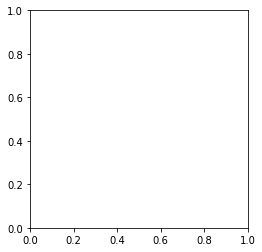

In [14]:
plt.imshow(frame)